# Info GAN - MNIST Dataset

In this notebook we are going to implement a fairly complicated GAN, called InfoGAN. This architecture is based on the paper, [InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets](https://arxiv.org/abs/1606.03657) by Chen et al.

The main problem this architecture is seeking to fix is the disentanglement issue, and using this approach is more widely used and known in community.

The interpretation of how InfoGAN work in high-level language is like this; we separate the model into two parts: 1. First part corresponding to truly random noise, 2. Second part is corresponding to the something we call "latent code".

The latent code can be thought as a "hidden" condition in a conditional generator, we actually want this to have an interpretable meaning.

It's the most likely that you are wondering how do we get the latent code, a set of random number to be more interpretable than any dimension in a GAN? The answer to this question is "Mutual Information". We want each dimension of the latent code to be as obvious a function as possible of generated images. We won't go any deeper than this, if you want to read more about this matter, I suggest read the reference paper and Information Entropy.

The implementation of InfoGAN is much like before, generator is just like previous models, but the discriminators will undergo some changes. To be more specific, it will be modified in a way so more dimensions are present in its output.

Architecture of this network is:

Generator:
1. Noise Vector: (64 + 2)
2. Block 1: [ConvTranspose(66, 256), Filter: 3, Stride: 2] -> Batch Normalization (256) -> ReLU
3. Block 2: [ConvTranspose(256, 128), Filter: 4, Stride: 1] -> Batch Normalization (128) -> ReLU
4. Block 3: [ConvTranspose(128, 64), Filter: 3, Stride: 2] -> Batch Normalization (64) -> ReLU
5. Block 4: [ConvTranspose(64, 1), Filter: 4, Stride: 2] -> TanH

Discriminator:
1. Image: (28, 28, 1)*
2. Block 1: [Conv2D(1, 64), Filter: 4, Stride: 2 -> Batch Normalization (64) -> LeakyReLU (0.2)
3. Block 2: [Conv2D(64, 128), Filter: 4, Stride: 2] -> Batch Normalization (128) -> LeakyReLU (0.2)
4. D Layer: [Conv2D(128, 1), Filter: 4, Stride: 2]
5. Q Layer 1: [Conv2D(128, 128), Filter: 4, Stride: 2] -> Batch Normalization (128) -> LeakyReLU (0.2)
6. Q Layer 2: [Conv2D(128, 4), Filter: 1, Stride: 2]


*: In mathematics notation, the channel layer is presented as the third dimension but in tensor processing libraries it's presented as the first dimension of a cube. i.e. (1, 28, 28)

In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

def generate_noise(n_samples, noise_dim, device = 'cpu'):
    '''
    A Helper function for creating random noise vectors with the dimension of: (n_samples, noise_dim)
    random numbers are from normal distribution
    Input ->
        n_samples: number of samples to generate (row)
        noise_dim: dimension of nouse vector (column)
        device: device type
    '''
    return torch.randn(n_samples, noise_dim, device=device)

def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Input ->
      x: (n_samples, ?) the first vector. 
        This will be the noise vector of shape (n_samples, z_dim).
      y: (n_samples, ?) the second vector.
        Once again, in this example this will be the one-hot class vector 
        with the shape (n_samples, n_classes).
    '''
    combined = torch.cat([x.float(), y.float()], 1)
    return combined

## Generator

In [3]:
class Generator(nn.Module):
    '''
    This class is for generator.
    Inputs ->
        noise_dim: dimension of noise vector.
        image_channel: number of channels in images,(Since MNIST is black and white images have 1 channel.)
        hidden_dim: inner dimension of networks.
    '''
    def __init__(self, noise_dim=10, image_channel=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, hidden_dim*4, kernel_size=3, stride=2),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(inplace=True)
        )
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(inplace=True)
        )
        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=3, stride=2),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True)
        )
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, image_channel, kernel_size=4, stride=2),
            nn.Tanh()
        )
    
    def forward(self, noise):
        '''
        forward pass of generator.
        Input ->
            noise: noise tensor with shape of (number of samples, noise_dim)
        Output ->
            generated image
        '''
        out = noise.view(len(noise), self.noise_dim, 1, 1)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        return out

## Discriminator

As you can see in the beginning of this notebook, the final layer of discriminator has 4 channels as output instead of one. The reason behind this fact is that we have to predict a distribution for $c$ from $x$. Since we are assuming a normal prior, we can output a mean and a log-variance prediction.

In [10]:
class Discriminator(nn.Module):
    '''
    This class is for Dsicriminator
    Input ->
        image_channel: number of channels in images,(Since MNIST is black and white images have 1 channel.)
        hidden_dim: inner dimension of networks.
        c_dim: number of latent code dimensions
    '''
    def __init__(self, image_channel=1, hidden_dim=64, c_dim=10):
        super(Discriminator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(image_channel, hidden_dim, kernel_size=4, stride=2),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(.2, inplace=True)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(.2, inplace=True)
        )
        self.d_layer = nn.Conv2d(hidden_dim * 2, 1, kernel_size=4, stride=2)
        self.q_layer1 = nn.Sequential(
            nn.Conv2d(hidden_dim * 2, hidden_dim * 2, kernel_size=4, stride=2),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(.2, inplace=True)
        )
        self.q_layer2 = nn.Conv2d(hidden_dim * 2, c_dim * 2, kernel_size=1, stride=2)
    
    def forward(self, image):
        '''
        Forward pass of discriminator
        Input ->
            image: flattened image tensor with dimension of (image_dim)
        Output ->
            returns a 1 dimension tensor representing whtether input image is generated or original.
        '''
        out = self.block1(image)
        intermed_pred = self.block2(out)
        disc_pred = self.d_layer(intermed_pred)
        q_pred = self.q_layer1(intermed_pred)
        q_pred = self.q_layer2(q_pred)
        return disc_pred.view(len(disc_pred), -1), q_pred.view(len(q_pred), -1)

## Training
In the next cell we are going to implement some hyperparameters and start training the network. Most of them are like previous networks but three of them are newly added and specific to InfoGAN, *c_dim*, *c_criterion* and *c_lambda* are them;

- mnist_shape: the shape of each sample in MNIST dataset, which are 1 x 28 x 28, 1 in the first position means images have 1 channel, thus they are black and white.
- adv_criterion: GAN loss function
- c_criterion: the additional mutual information term
- c_lambda: the weight on the c_criterion
- n_epochs: number of epochs
- noise_dim: dimension of noise vector
- c_dim: dimension of InfoGAN latent code
- display_step: how often samples are displayed from Generator
- batch_size: the number of samples per forward/backward pass
- lr: InfoGAN uses two learning rates:
  - d_lr: discriminator learning rate
  - g_lr: generator learning rate
- device: the device that training performed on

In [5]:
from torch.distributions.normal import Normal
adv_criterion = nn.BCEWithLogitsLoss()
c_criterion = lambda c_true, mean, logvar: Normal(mean, logvar.exp()).log_prob(c_true).mean()
c_lambda = 0.1
mnist_shape = (1, 28, 28)
n_epochs = 80
noise_dim = 64
c_dim = 2
display_step = 500
batch_size = 128
d_lr = 2e-4
g_lr = 1e-3
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('./data', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Network initialization can be done like before.
If you have read the original paper, you might notice that we are not using separate $Q$ network. There are some design choices that are worthy to point to:
1. The distribution over the latent code can be in multiple forms and choices can be made. We can use a Gaussian prior, Categorical prior or using them together. If we are going to use both of them together, we can use different weights of $\lambda$ on both prior distributions.
2. You can calculate the mutual information explicitly, including $H(c)$ which you treat as constant here. You don't do that here since you're not comparing the mutual information of different parameterizations of the latent code.
3. $Q$ network can be handled in multiple ways, here we are using original paper, thus treating it as a part of the discriminator. In this approach most weights are shared. Another approach it to initialize another network.

In [6]:
gen = Generator(noise_dim=noise_dim + c_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=g_lr)
disc = Discriminator(image_channel=mnist_shape[0], c_dim=c_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=d_lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  7%|▋         | 31/469 [00:07<01:50,  3.98it/s]

Epoch 1, step 500 -> Generator loss: 2.9549732012748717, discriminator loss: 0.08807141828164458


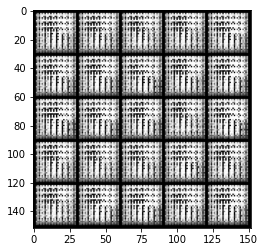

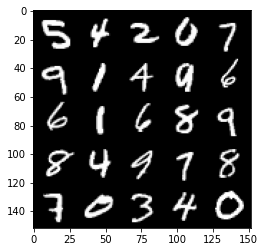

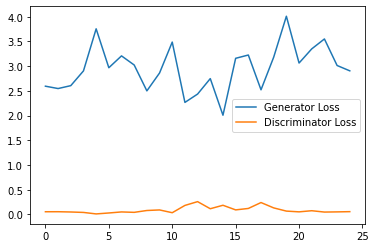

 13%|█▎        | 62/469 [00:17<01:56,  3.51it/s]

Epoch 2, step 1000 -> Generator loss: 3.682192834854126, discriminator loss: 0.03458433126658201


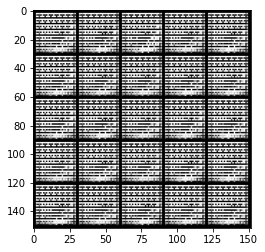

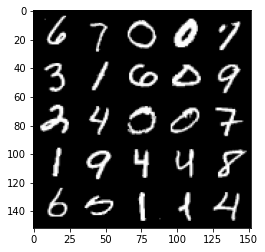

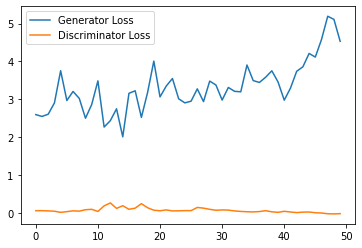

 20%|█▉        | 93/469 [00:23<01:36,  3.91it/s]

Epoch 3, step 1500 -> Generator loss: 4.530659802436829, discriminator loss: -0.005787337224930525


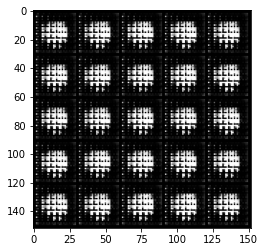

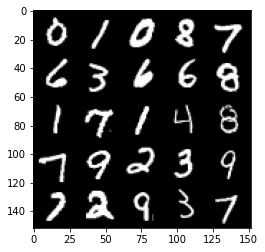

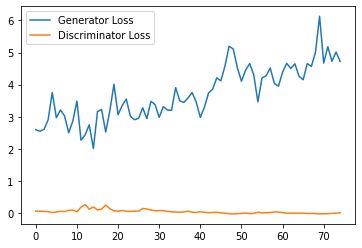

 26%|██▋       | 124/469 [00:28<01:18,  4.41it/s]

Epoch 4, step 2000 -> Generator loss: 4.332539824485779, discriminator loss: 0.0028659960022196173


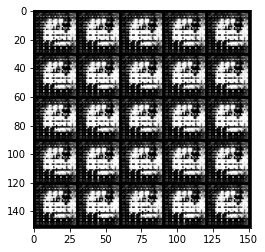

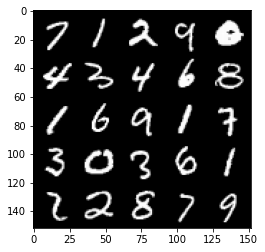

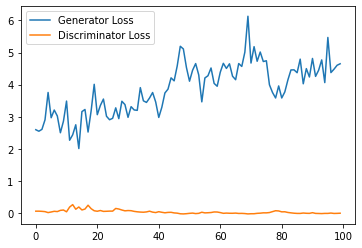

 33%|███▎      | 155/469 [00:28<00:55,  5.65it/s]

Epoch 5, step 2500 -> Generator loss: 4.451666277885437, discriminator loss: 0.006874906443525106


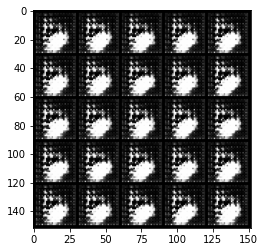

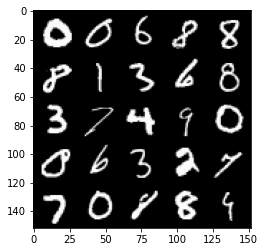

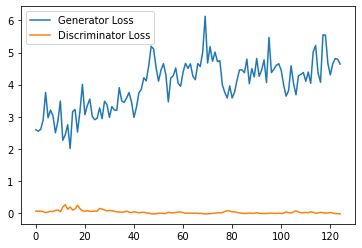

 40%|███▉      | 186/469 [00:34<00:51,  5.47it/s]

Epoch 6, step 3000 -> Generator loss: 3.9313269662857055, discriminator loss: 0.09432724550366402


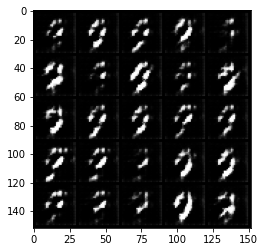

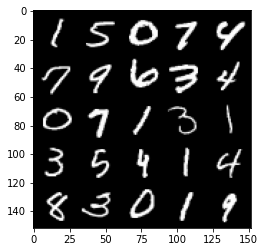

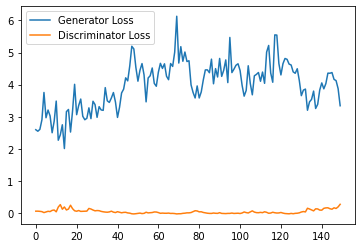

 46%|████▋     | 217/469 [00:39<00:46,  5.44it/s]

Epoch 7, step 3500 -> Generator loss: 3.0817074401378632, discriminator loss: 0.24833913743495942


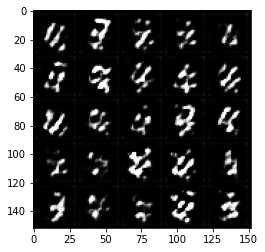

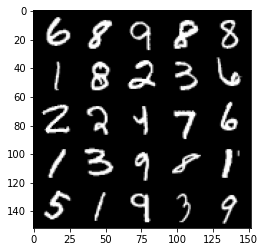

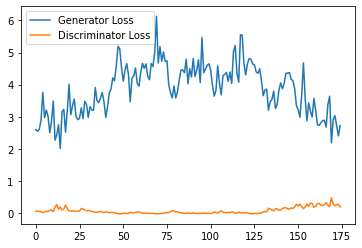

 53%|█████▎    | 248/469 [00:56<00:49,  4.48it/s]

Epoch 8, step 4000 -> Generator loss: 2.777668998003006, discriminator loss: 0.21782950930297373


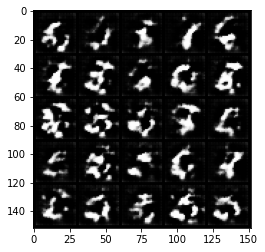

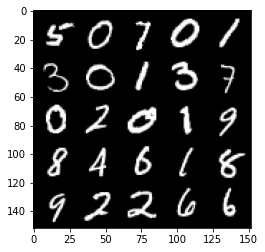

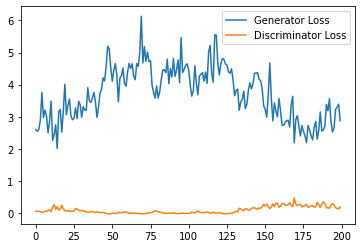

 59%|█████▉    | 279/469 [01:07<00:43,  4.38it/s]

Epoch 9, step 4500 -> Generator loss: 2.544597770214081, discriminator loss: 0.23463106952607632


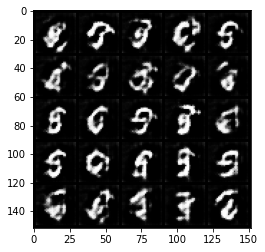

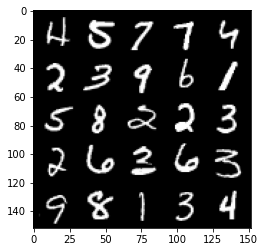

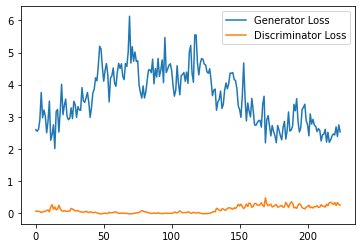

 66%|██████▌   | 310/469 [01:10<00:37,  4.29it/s]

Epoch 10, step 5000 -> Generator loss: 2.5970246217250823, discriminator loss: 0.21018391588330268


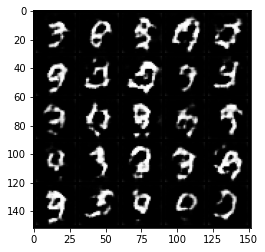

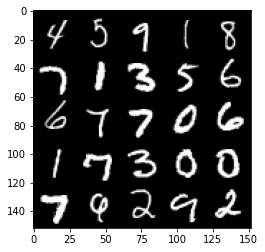

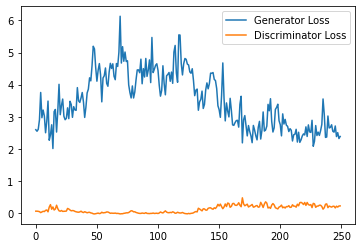

 73%|███████▎  | 341/469 [00:58<00:21,  5.88it/s]

Epoch 11, step 5500 -> Generator loss: 2.5359388144016264, discriminator loss: 0.21859777222573756


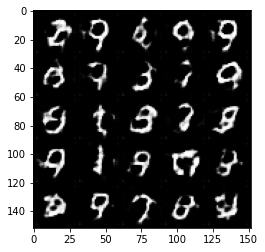

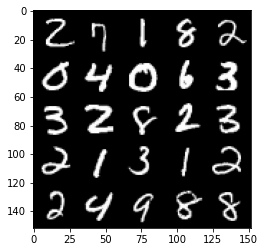

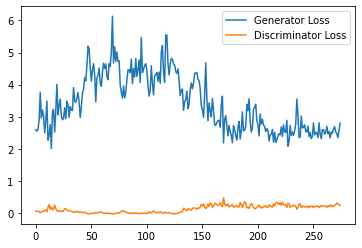

 79%|███████▉  | 372/469 [01:06<00:21,  4.43it/s]

Epoch 12, step 6000 -> Generator loss: 2.3652119736671446, discriminator loss: 0.2992275681197643


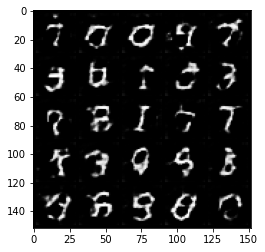

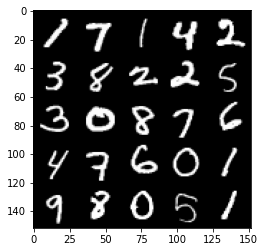

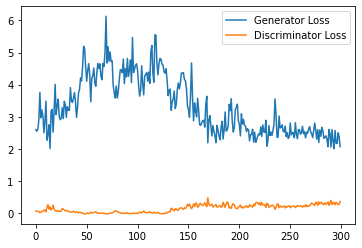

 86%|████████▌ | 403/469 [01:31<00:15,  4.31it/s]

Epoch 13, step 6500 -> Generator loss: 2.216742975831032, discriminator loss: 0.3277756321132183


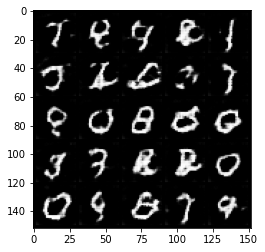

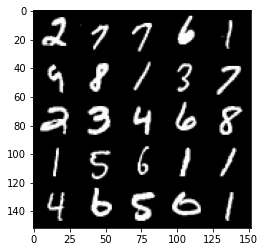

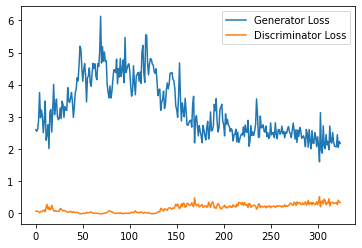

 93%|█████████▎| 434/469 [01:38<00:07,  4.38it/s]

Epoch 14, step 7000 -> Generator loss: 1.984000577569008, discriminator loss: 0.3841301390826702


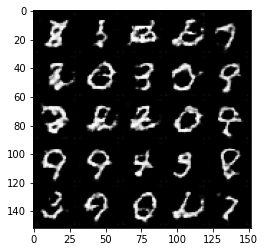

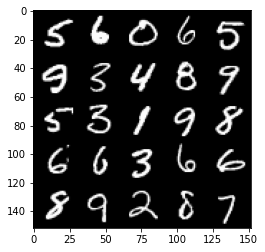

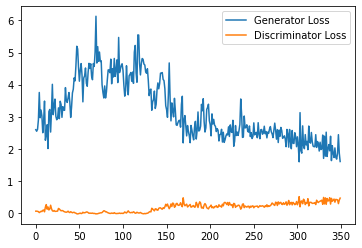

 99%|█████████▉| 465/469 [01:20<00:00,  5.60it/s]

Epoch 15, step 7500 -> Generator loss: 1.8222056835889817, discriminator loss: 0.41802945506572725


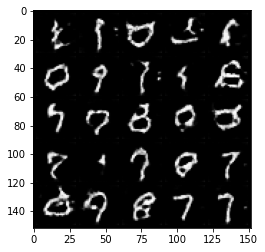

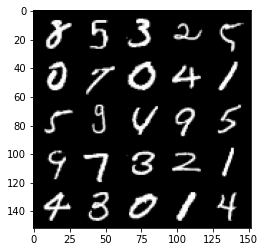

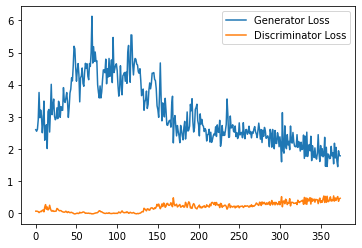

  6%|▌         | 27/469 [00:04<01:17,  5.70it/s]

Epoch 17, step 8000 -> Generator loss: 1.7598434534072875, discriminator loss: 0.45217589566111566


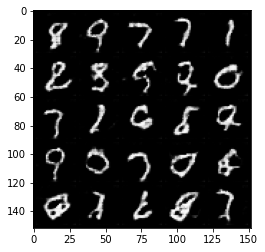

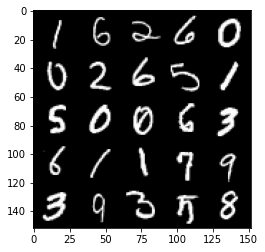

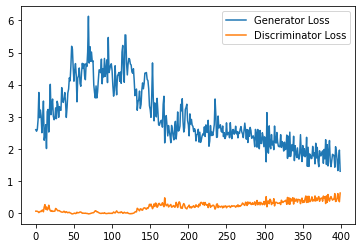

 12%|█▏        | 58/469 [00:14<01:40,  4.09it/s]

Epoch 18, step 8500 -> Generator loss: 1.6027179260253905, discriminator loss: 0.49196953558921813


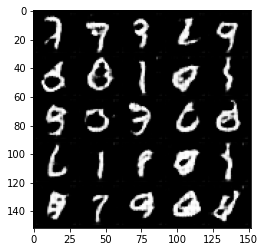

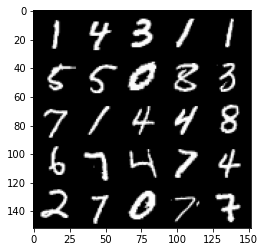

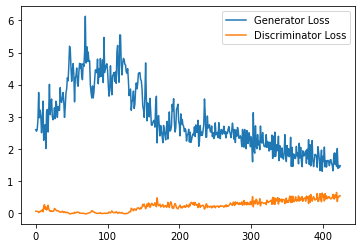

 19%|█▉        | 89/469 [00:20<01:27,  4.33it/s]

Epoch 19, step 9000 -> Generator loss: 1.5872552089691163, discriminator loss: 0.49593199717998504


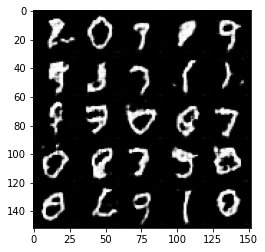

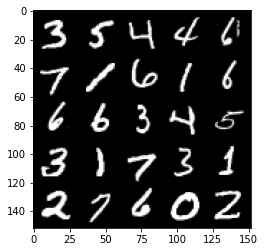

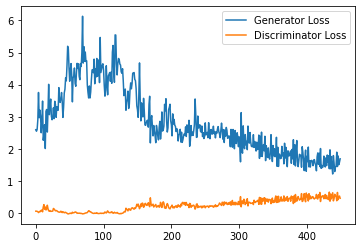

 26%|██▌       | 120/469 [00:27<01:18,  4.44it/s]

Epoch 20, step 9500 -> Generator loss: 1.576717889547348, discriminator loss: 0.5124104844927788


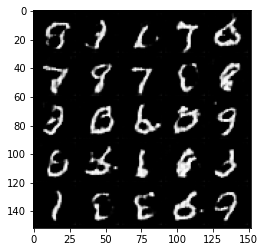

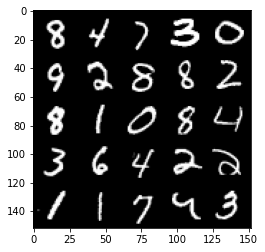

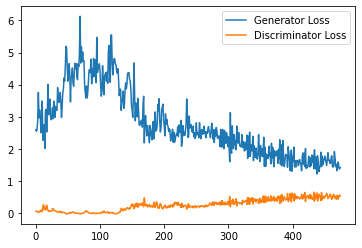

 32%|███▏      | 151/469 [00:34<01:12,  4.38it/s]

Epoch 21, step 10000 -> Generator loss: 1.530538902401924, discriminator loss: 0.536844935297966


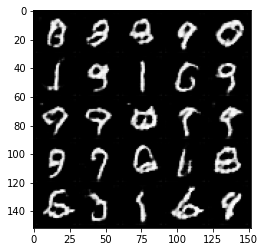

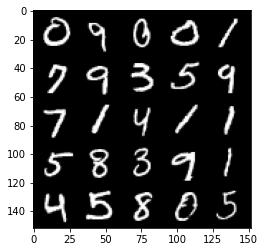

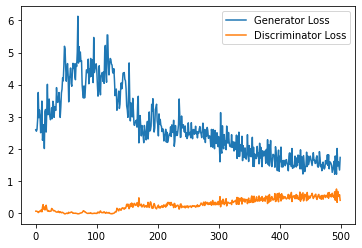

 39%|███▉      | 182/469 [00:30<00:47,  6.10it/s]

Epoch 22, step 10500 -> Generator loss: 1.4562326780557633, discriminator loss: 0.5270773286223411


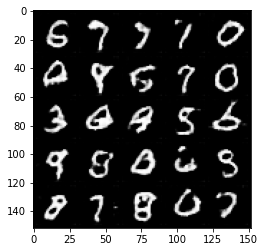

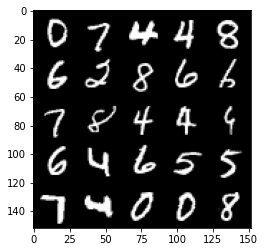

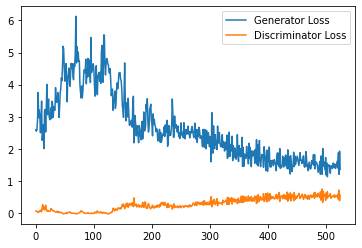

 45%|████▌     | 213/469 [00:35<00:42,  6.08it/s]

Epoch 23, step 11000 -> Generator loss: 1.4038357117176057, discriminator loss: 0.5303821791410446


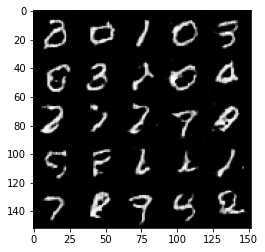

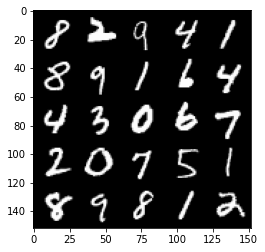

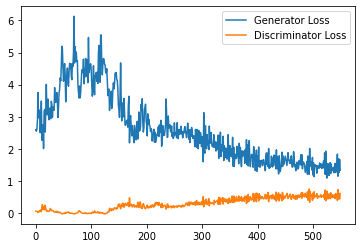

 52%|█████▏    | 244/469 [00:40<00:37,  6.08it/s]

Epoch 24, step 11500 -> Generator loss: 1.4581432723999024, discriminator loss: 0.5177602535486221


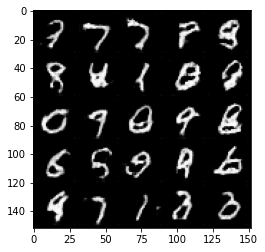

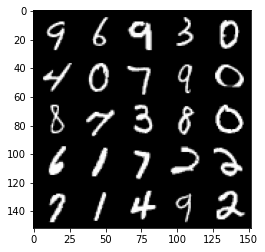

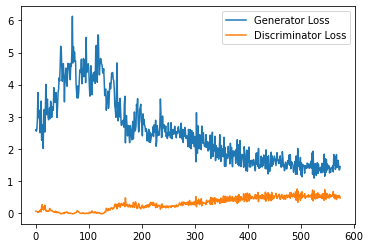

 59%|█████▊    | 275/469 [00:45<00:31,  6.13it/s]

Epoch 25, step 12000 -> Generator loss: 1.3987316769361495, discriminator loss: 0.5424767836332322


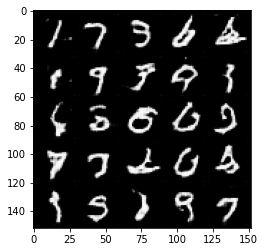

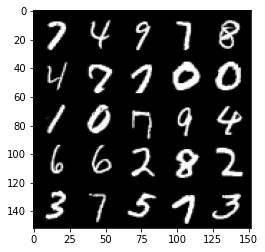

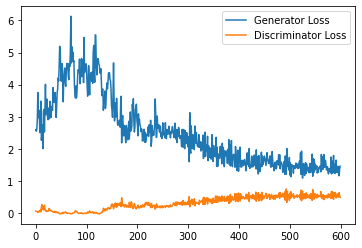

 65%|██████▌   | 306/469 [01:00<00:40,  4.00it/s]

Epoch 26, step 12500 -> Generator loss: 1.4945509214401245, discriminator loss: 0.5491731451749802


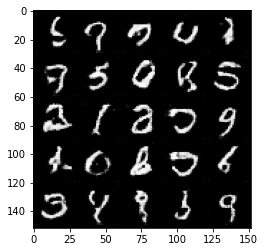

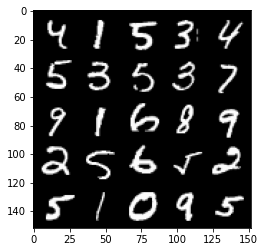

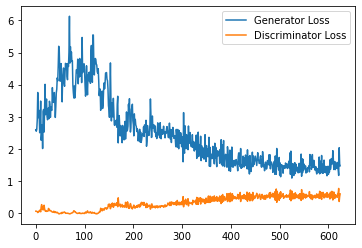

 72%|███████▏  | 337/469 [01:35<00:36,  3.57it/s]

Epoch 27, step 13000 -> Generator loss: 1.3144623923301697, discriminator loss: 0.5656103157997131


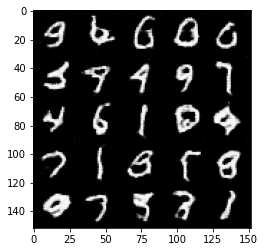

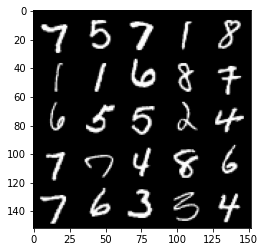

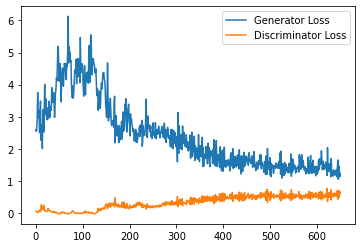

 78%|███████▊  | 368/469 [01:13<00:27,  3.68it/s]

Epoch 28, step 13500 -> Generator loss: 1.308782446026802, discriminator loss: 0.5579915800094605


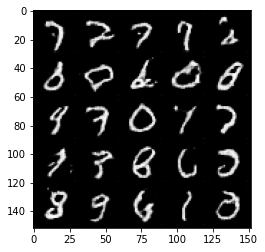

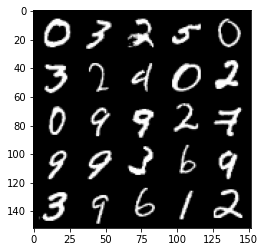

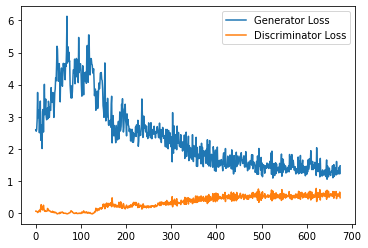

 85%|████████▌ | 399/469 [02:23<00:24,  2.85it/s]

Epoch 29, step 14000 -> Generator loss: 1.3901904238462448, discriminator loss: 0.5645593116283417


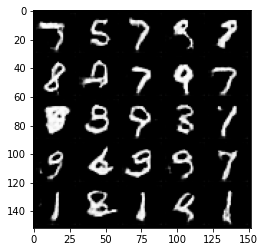

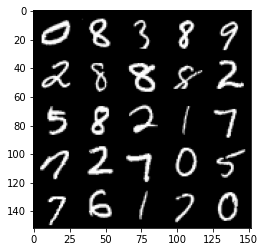

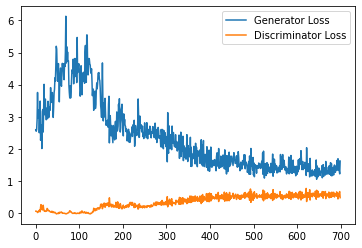

 92%|█████████▏| 430/469 [02:32<00:13,  2.85it/s]

Epoch 30, step 14500 -> Generator loss: 1.2839629521369935, discriminator loss: 0.5777352715730667


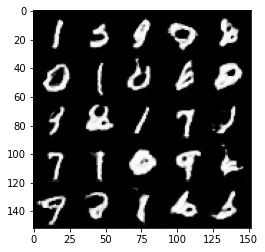

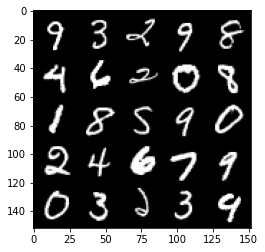

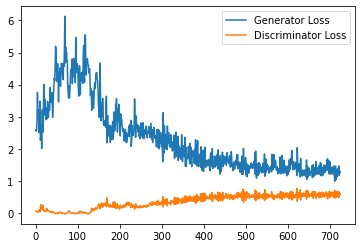

 98%|█████████▊| 461/469 [02:43<00:02,  2.82it/s]

Epoch 31, step 15000 -> Generator loss: 1.2999468295574188, discriminator loss: 0.5724243308305741


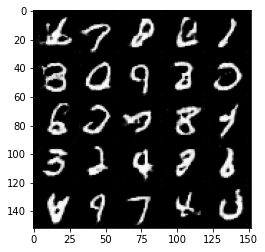

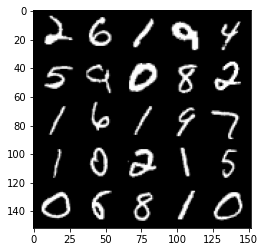

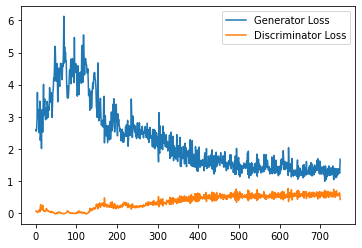

  5%|▍         | 23/469 [00:08<02:39,  2.80it/s]

Epoch 33, step 15500 -> Generator loss: 1.2278957730531692, discriminator loss: 0.5796979337334632


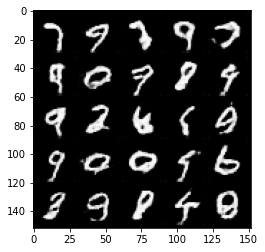

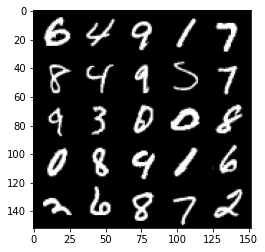

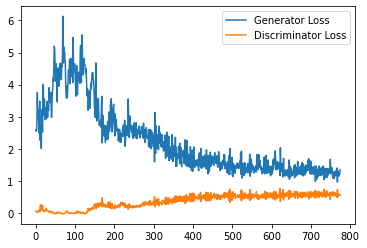

 12%|█▏        | 54/469 [00:18<02:19,  2.98it/s]

Epoch 34, step 16000 -> Generator loss: 1.3281930150985717, discriminator loss: 0.5712922889590263


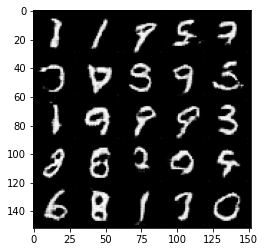

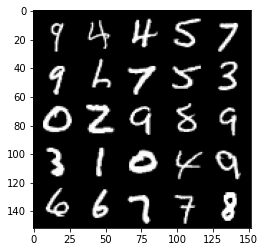

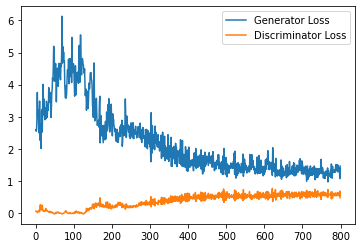

 18%|█▊        | 85/469 [00:27<01:35,  4.02it/s]

Epoch 35, step 16500 -> Generator loss: 1.2921956367492675, discriminator loss: 0.5639120259284973


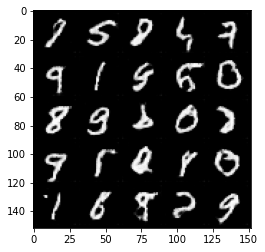

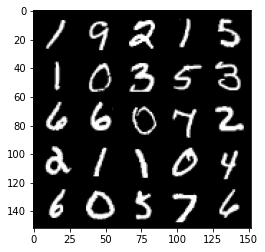

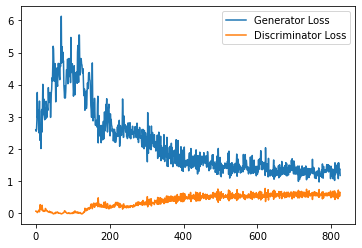

 25%|██▍       | 116/469 [00:26<01:30,  3.91it/s]

Epoch 36, step 17000 -> Generator loss: 1.2969064490795135, discriminator loss: 0.5553659757375717


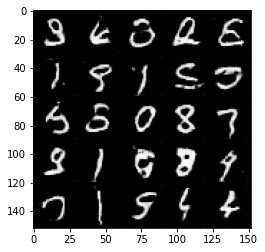

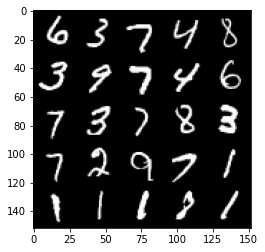

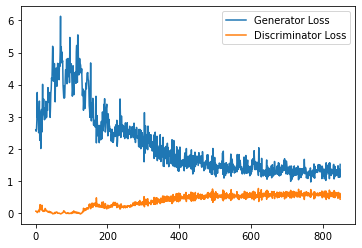

 31%|███▏      | 147/469 [00:26<00:58,  5.49it/s]

Epoch 37, step 17500 -> Generator loss: 1.1991418772935867, discriminator loss: 0.5619791121482849


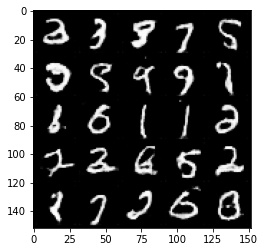

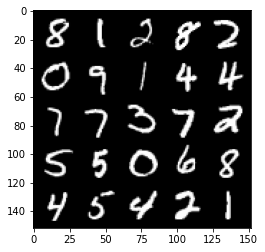

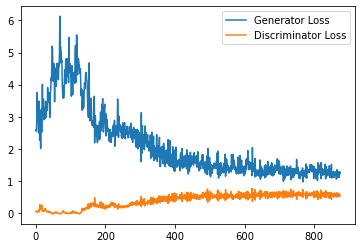

 38%|███▊      | 178/469 [00:32<00:52,  5.58it/s]

Epoch 38, step 18000 -> Generator loss: 1.2557881968021394, discriminator loss: 0.556610814332962


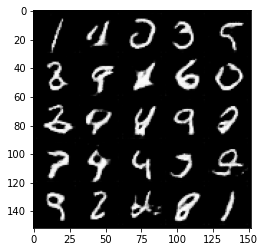

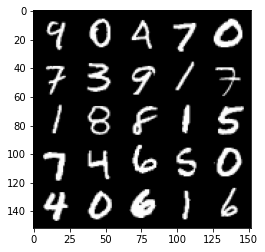

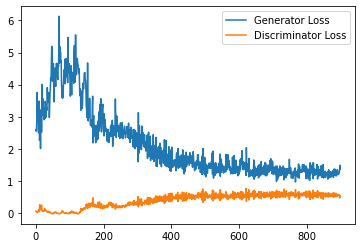

 45%|████▍     | 209/469 [00:37<00:46,  5.59it/s]

Epoch 39, step 18500 -> Generator loss: 1.2246833831071853, discriminator loss: 0.5671639596223831


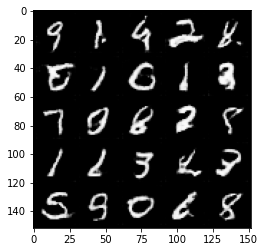

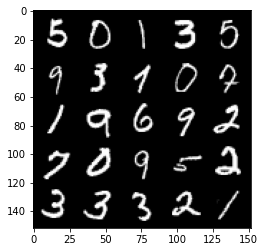

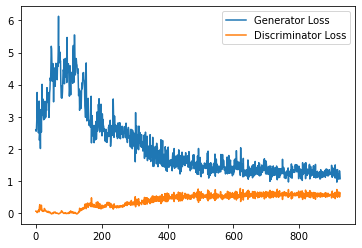

 51%|█████     | 240/469 [00:43<00:41,  5.48it/s]

Epoch 40, step 19000 -> Generator loss: 1.271177632689476, discriminator loss: 0.553467162847519


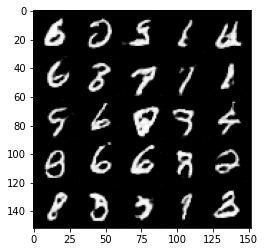

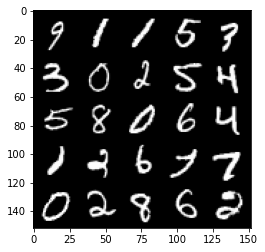

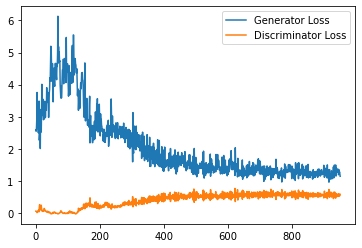

 58%|█████▊    | 271/469 [00:49<00:45,  4.40it/s]

Epoch 41, step 19500 -> Generator loss: 1.229289281129837, discriminator loss: 0.5482637670636177


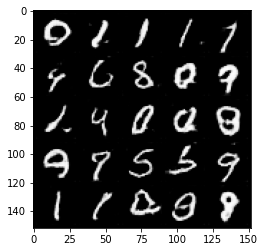

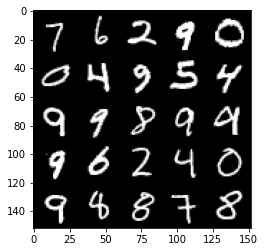

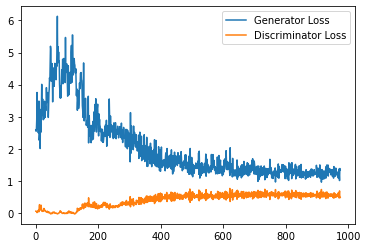

 64%|██████▍   | 302/469 [01:09<00:37,  4.45it/s]

Epoch 42, step 20000 -> Generator loss: 1.2426041561365126, discriminator loss: 0.5509889396429062


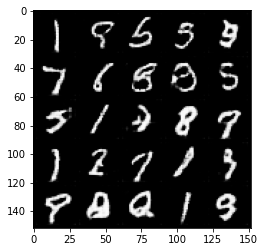

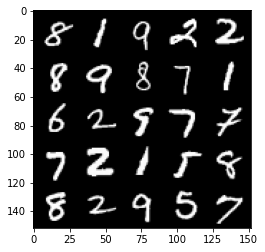

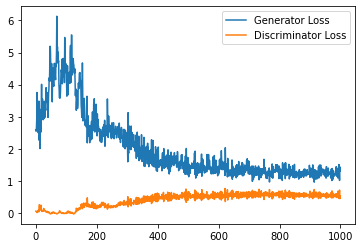

 71%|███████   | 333/469 [01:16<00:31,  4.39it/s]

Epoch 43, step 20500 -> Generator loss: 1.1844958959817886, discriminator loss: 0.5500130875110626


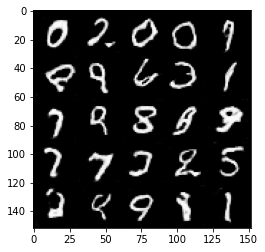

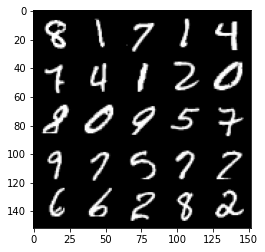

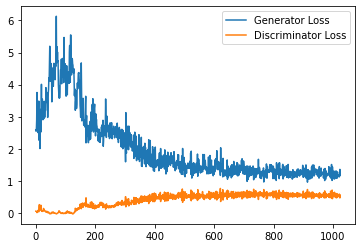

 78%|███████▊  | 364/469 [01:22<00:23,  4.40it/s]

Epoch 44, step 21000 -> Generator loss: 1.182455218553543, discriminator loss: 0.5491534376740456


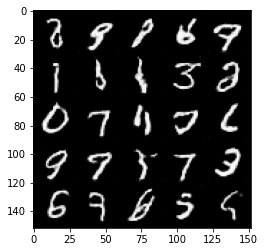

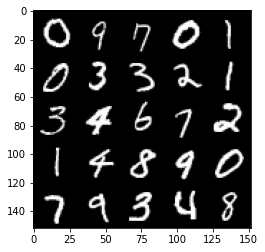

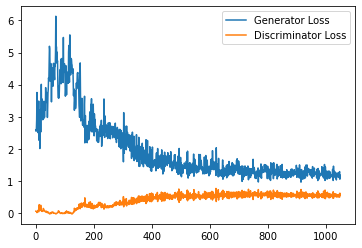

 84%|████████▍ | 395/469 [01:29<00:16,  4.41it/s]

Epoch 45, step 21500 -> Generator loss: 1.2104476615190507, discriminator loss: 0.5373547505140305


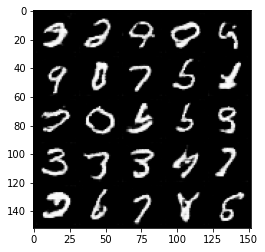

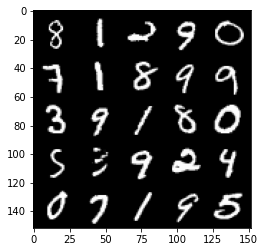

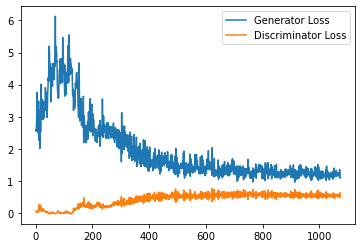

 91%|█████████ | 426/469 [01:17<00:07,  5.61it/s]

Epoch 46, step 22000 -> Generator loss: 1.2390946283340454, discriminator loss: 0.5306909017562866


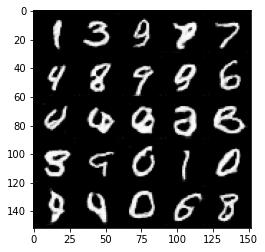

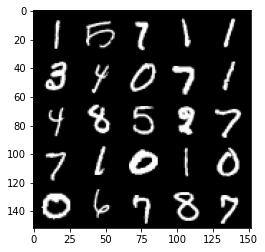

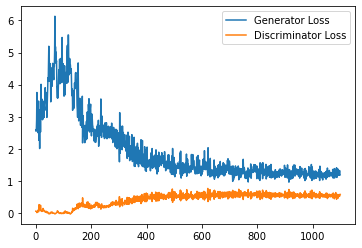

 97%|█████████▋| 457/469 [01:39<00:02,  4.45it/s]

Epoch 47, step 22500 -> Generator loss: 1.2494733664989472, discriminator loss: 0.5268345671892166


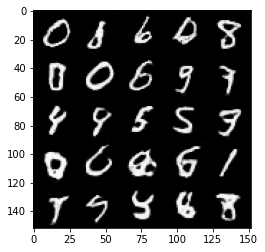

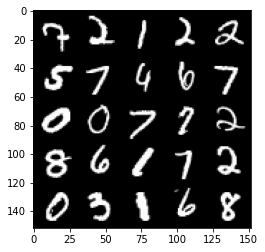

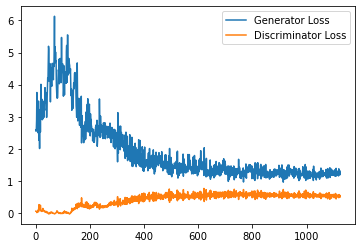

  4%|▍         | 19/469 [00:04<01:41,  4.44it/s]

Epoch 49, step 23000 -> Generator loss: 1.2099736877679825, discriminator loss: 0.5264859567284584


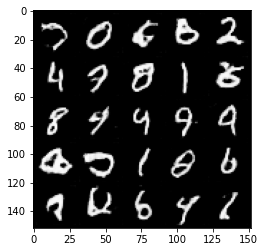

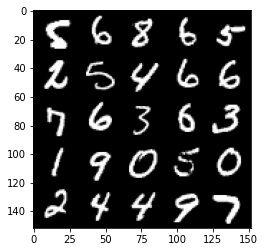

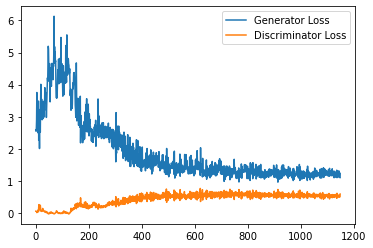

 11%|█         | 50/469 [00:08<01:11,  5.85it/s]

Epoch 50, step 23500 -> Generator loss: 1.2164585757255555, discriminator loss: 0.5199945308566093


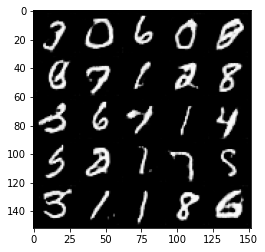

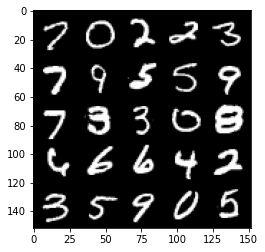

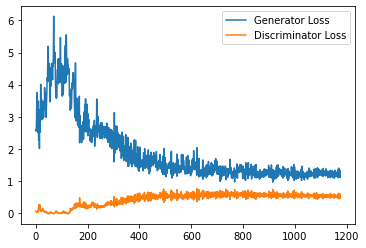

 17%|█▋        | 81/469 [00:13<01:08,  5.69it/s]

Epoch 51, step 24000 -> Generator loss: 1.1872311989068984, discriminator loss: 0.5194987059235573


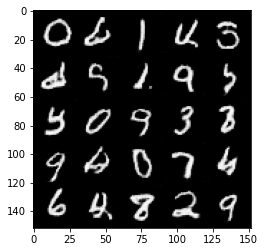

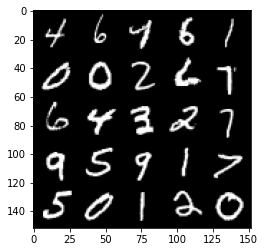

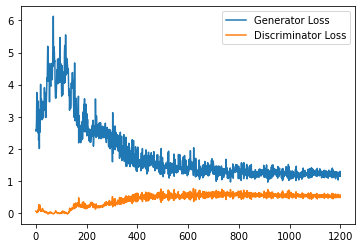

 24%|██▍       | 112/469 [00:25<01:21,  4.36it/s]

Epoch 52, step 24500 -> Generator loss: 1.2547623983621596, discriminator loss: 0.5099956058859825


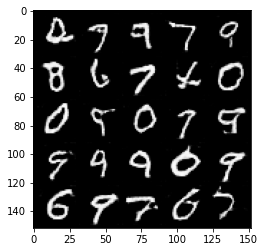

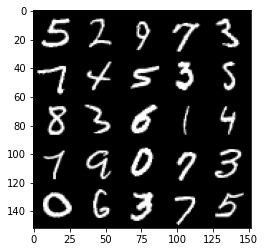

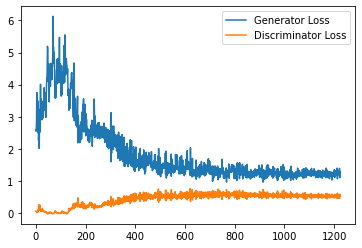

 30%|███       | 143/469 [00:24<00:53,  6.07it/s]

Epoch 53, step 25000 -> Generator loss: 1.2584559217691422, discriminator loss: 0.5066384010910988


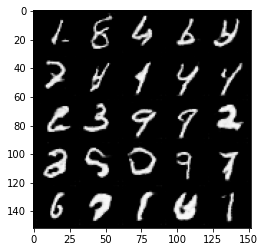

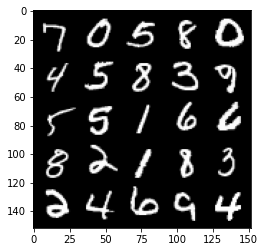

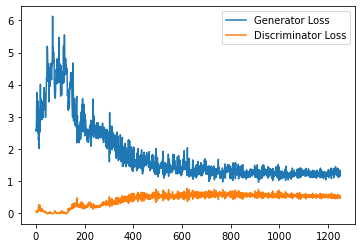

 37%|███▋      | 174/469 [00:33<01:26,  3.41it/s]

Epoch 54, step 25500 -> Generator loss: 1.2337883557081222, discriminator loss: 0.5054857730865479


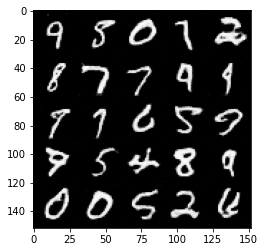

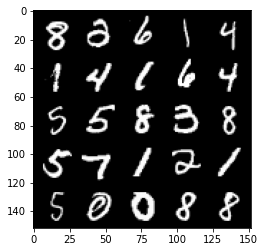

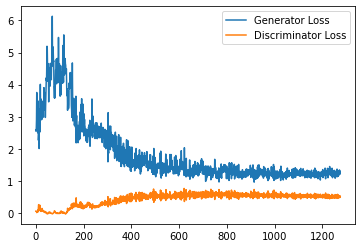

 44%|████▎     | 205/469 [00:57<01:06,  3.97it/s]

Epoch 55, step 26000 -> Generator loss: 1.2558111069202422, discriminator loss: 0.5102436147928238


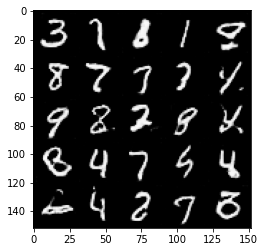

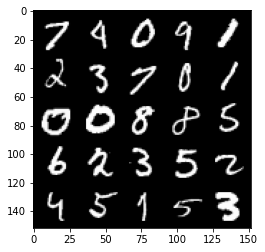

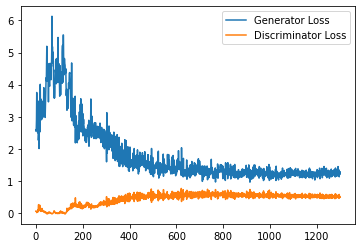

 50%|█████     | 236/469 [00:54<00:58,  3.98it/s]

Epoch 56, step 26500 -> Generator loss: 1.240660331606865, discriminator loss: 0.5033458761572838


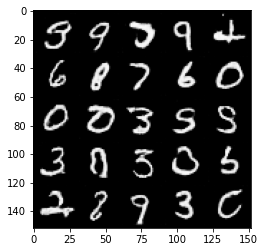

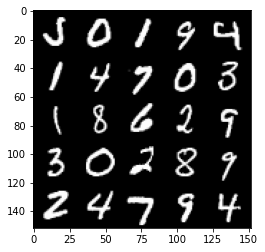

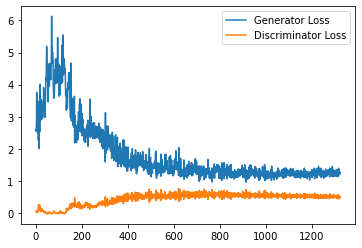

 57%|█████▋    | 267/469 [01:07<00:45,  4.41it/s]

Epoch 57, step 27000 -> Generator loss: 1.2279332998991013, discriminator loss: 0.5068405970931054


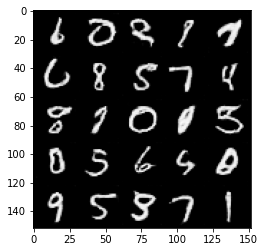

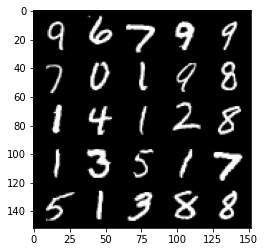

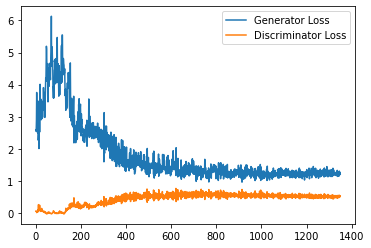

 64%|██████▎   | 298/469 [01:08<00:39,  4.34it/s]

Epoch 58, step 27500 -> Generator loss: 1.2370893611907958, discriminator loss: 0.5058725252151489


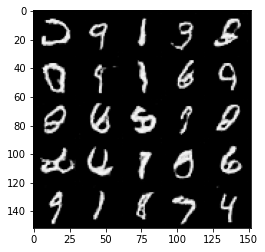

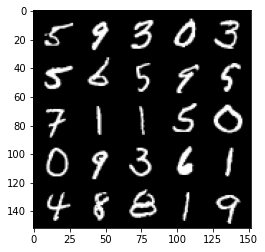

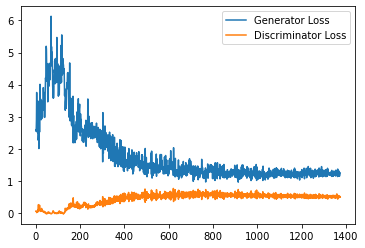

 70%|███████   | 329/469 [01:14<00:32,  4.37it/s]

Epoch 59, step 28000 -> Generator loss: 1.2178194843530654, discriminator loss: 0.5044077808260917


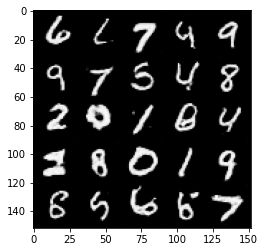

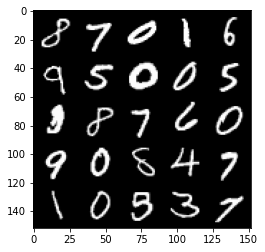

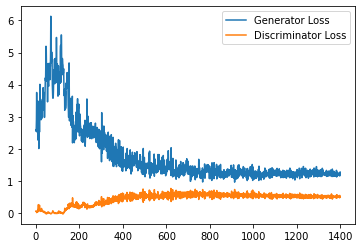

 77%|███████▋  | 360/469 [01:05<00:19,  5.52it/s]

Epoch 60, step 28500 -> Generator loss: 1.213785417199135, discriminator loss: 0.5068285115957261


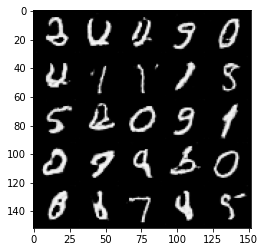

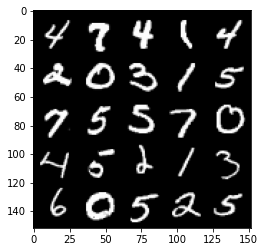

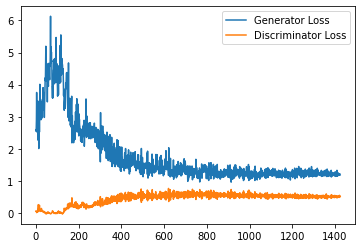

 83%|████████▎ | 391/469 [01:10<00:13,  5.57it/s]

Epoch 61, step 29000 -> Generator loss: 1.225765382170677, discriminator loss: 0.5045162163376808


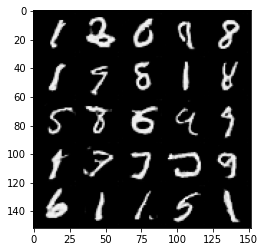

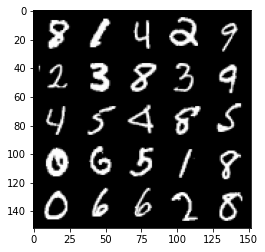

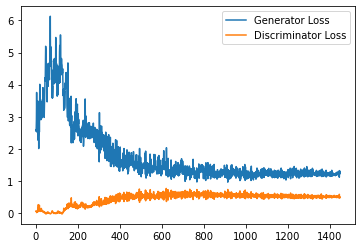

 90%|████████▉ | 422/469 [01:17<00:09,  4.79it/s]

Epoch 62, step 29500 -> Generator loss: 1.2290925180912018, discriminator loss: 0.5128500705361366


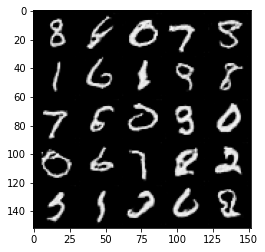

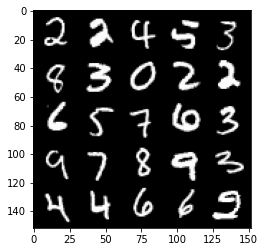

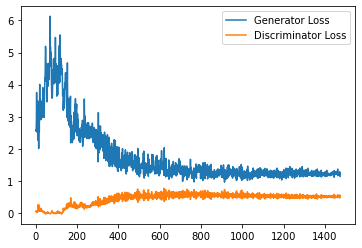

 97%|█████████▋| 453/469 [01:54<00:03,  4.06it/s]

Epoch 63, step 30000 -> Generator loss: 1.23278935277462, discriminator loss: 0.5073999791741372


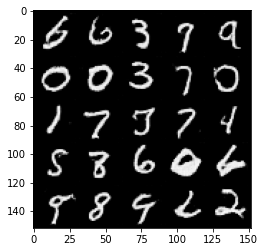

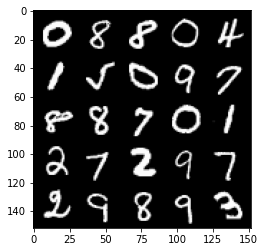

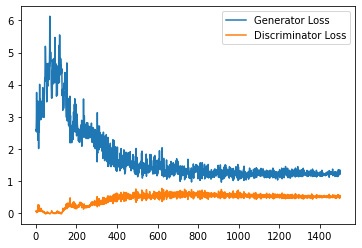

  3%|▎         | 15/469 [00:02<01:16,  5.92it/s]

Epoch 65, step 30500 -> Generator loss: 1.2279902321100236, discriminator loss: 0.5146798594594002


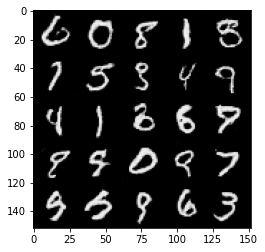

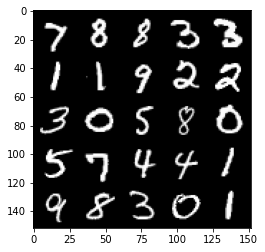

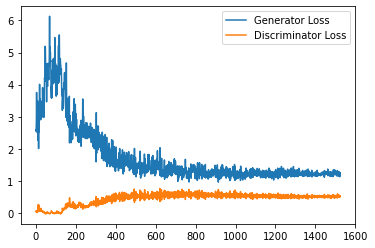

 10%|▉         | 46/469 [00:11<01:41,  4.15it/s]

Epoch 66, step 31000 -> Generator loss: 1.1967286710739136, discriminator loss: 0.513687871158123


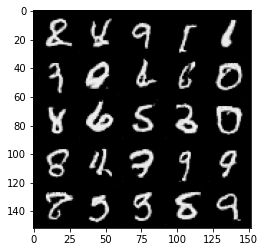

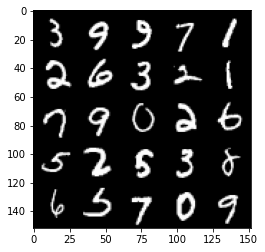

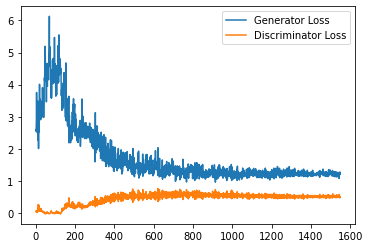

 16%|█▋        | 77/469 [00:13<01:11,  5.46it/s]

Epoch 67, step 31500 -> Generator loss: 1.2133126900196076, discriminator loss: 0.519723758161068


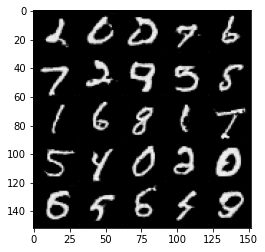

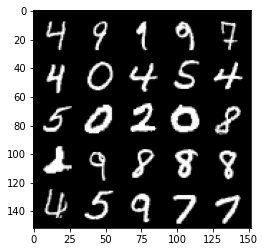

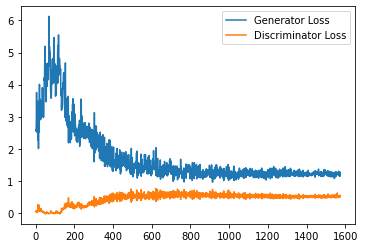

 23%|██▎       | 108/469 [00:19<01:07,  5.35it/s]

Epoch 68, step 32000 -> Generator loss: 1.2403504539728165, discriminator loss: 0.5180010198950767


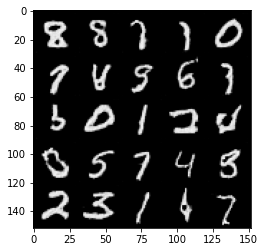

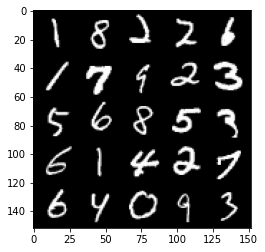

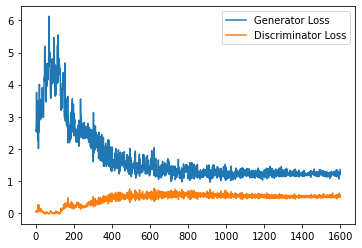

 30%|██▉       | 139/469 [00:25<00:59,  5.56it/s]

Epoch 69, step 32500 -> Generator loss: 1.214615091562271, discriminator loss: 0.5179496424794197


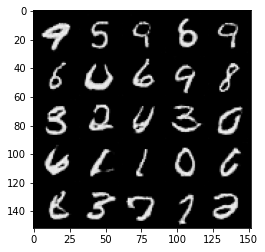

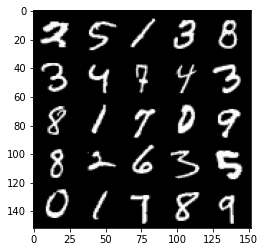

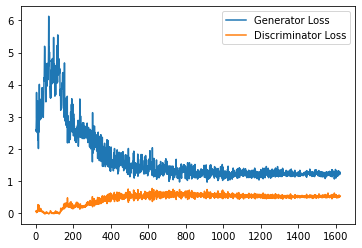

 36%|███▌      | 170/469 [00:30<00:53,  5.61it/s]

Epoch 70, step 33000 -> Generator loss: 1.211344436764717, discriminator loss: 0.524645802974701


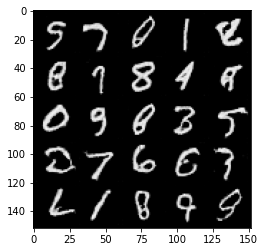

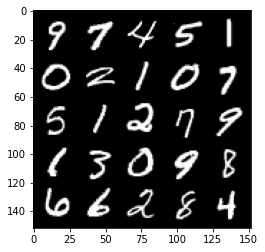

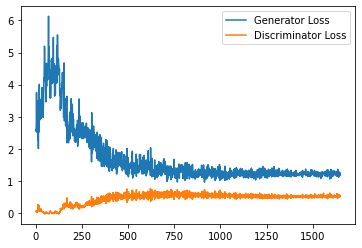

 43%|████▎     | 201/469 [00:36<00:48,  5.54it/s]

Epoch 71, step 33500 -> Generator loss: 1.2232769631147384, discriminator loss: 0.5230924919843674


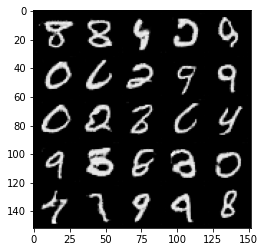

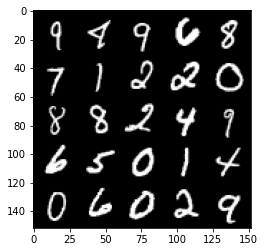

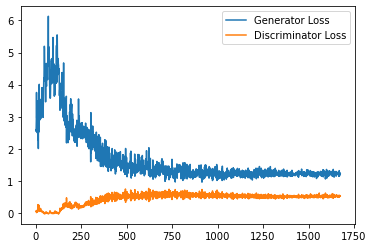

 49%|████▉     | 232/469 [00:42<00:43,  5.45it/s]

Epoch 72, step 34000 -> Generator loss: 1.2289471980333329, discriminator loss: 0.5160842314362526


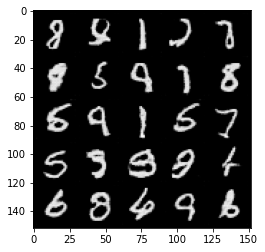

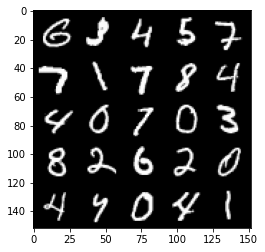

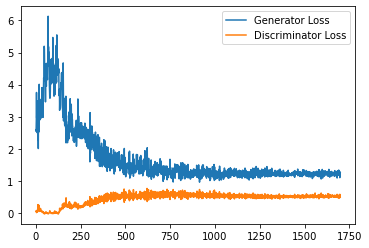

 56%|█████▌    | 263/469 [00:59<00:46,  4.42it/s]

Epoch 73, step 34500 -> Generator loss: 1.2380385228395463, discriminator loss: 0.5209517047405243


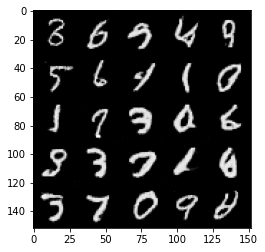

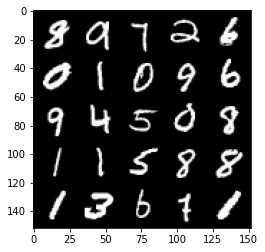

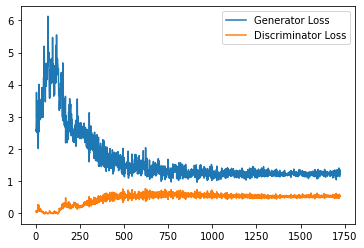

 63%|██████▎   | 294/469 [01:12<00:40,  4.27it/s]

Epoch 74, step 35000 -> Generator loss: 1.1998194335699082, discriminator loss: 0.528637555718422


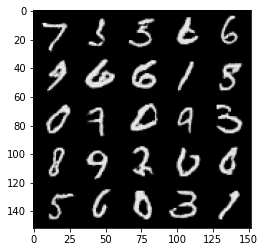

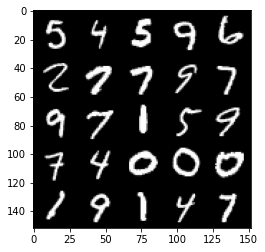

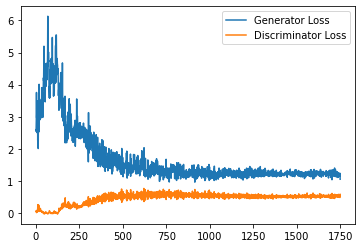

 69%|██████▉   | 325/469 [01:20<00:35,  4.05it/s]

Epoch 75, step 35500 -> Generator loss: 1.2131720525026322, discriminator loss: 0.5266044072508812


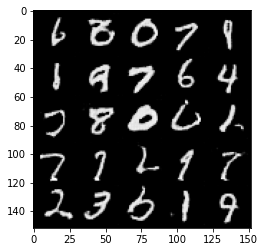

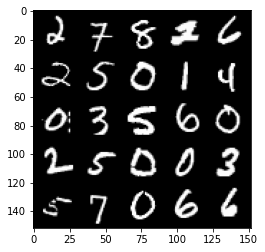

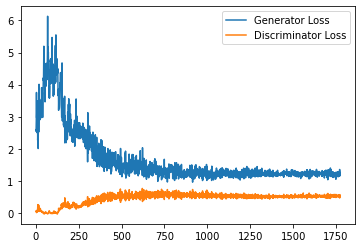

 76%|███████▌  | 356/469 [01:08<00:25,  4.35it/s]

Epoch 76, step 36000 -> Generator loss: 1.207217975139618, discriminator loss: 0.527427608013153


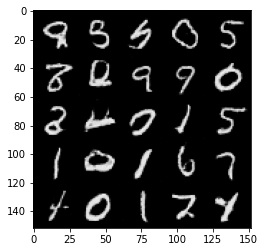

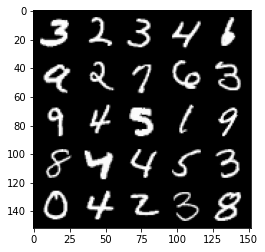

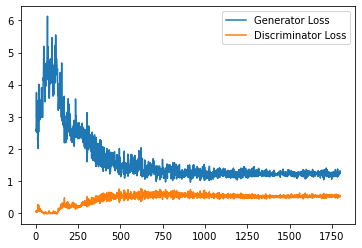

 83%|████████▎ | 387/469 [01:37<00:25,  3.21it/s]

Epoch 77, step 36500 -> Generator loss: 1.2500211120843887, discriminator loss: 0.5313397006988525


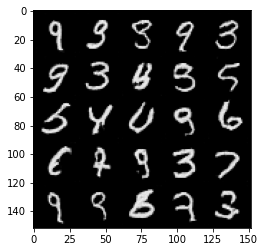

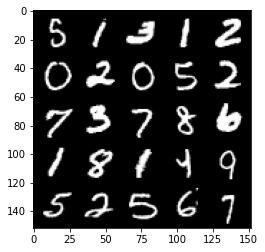

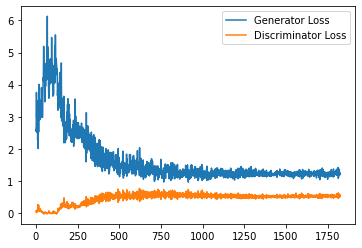

 89%|████████▉ | 418/469 [02:09<00:16,  3.13it/s]

Epoch 78, step 37000 -> Generator loss: 1.214371816277504, discriminator loss: 0.5232939624786377


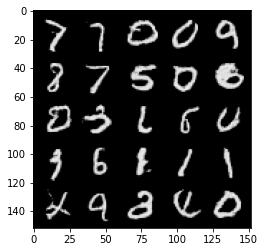

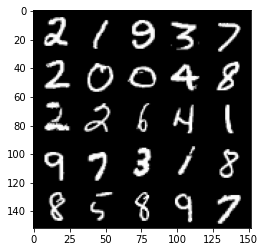

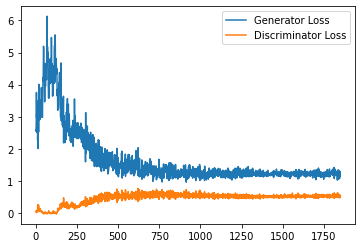

 96%|█████████▌| 449/469 [02:18<00:06,  3.24it/s]

Epoch 79, step 37500 -> Generator loss: 1.2017840908765793, discriminator loss: 0.5276531284451484


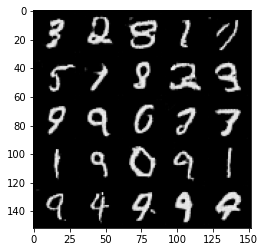

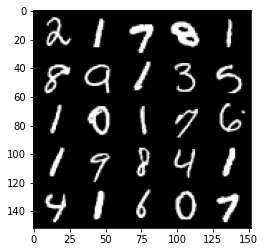

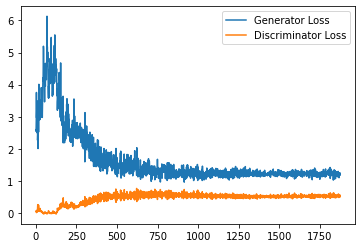

100%|██████████| 469/469 [02:26<00:00,  3.21it/s]


In [20]:
cur_step = 0
generator_losses = []
discriminator_losses = []

for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for original, _ in tqdm(dataloader):
        cur_batch_size = len(original)
        # Flatten the batch of original images from the dataset
        original = original.to(device)

        c_labels = generate_noise(cur_batch_size, c_dim, device=device)    
        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        generated_noise = generate_noise(cur_batch_size, noise_dim, device=device)
        # Combine the noise vectors and the one-hot labels for the generator
        noise_and_labels = combine_vectors(generated_noise, c_labels)
        # Generate the conditioned generated images
        generated = gen(noise_and_labels)
        
        # Get the discriminator's predictions
        disc_generated_pred, disc_q_pred = disc(generated.detach())
        disc_q_mean = disc_q_pred[:, :c_dim]
        disc_q_logvar = disc_q_pred[:, c_dim:]
        mutual_information = c_criterion(c_labels, disc_q_mean, disc_q_logvar)
        disc_original_pred, _ = disc(original)
        disc_generated_loss = adv_criterion(disc_generated_pred, torch.zeros_like(disc_generated_pred))
        disc_original_loss = adv_criterion(disc_original_pred, torch.ones_like(disc_original_pred))
        disc_loss = (disc_generated_loss + disc_original_loss) / 2 - c_lambda * mutual_information
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        disc_generated_pred, disc_q_pred = disc(generated)
        disc_q_mean = disc_q_pred[:, :c_dim]
        disc_q_logvar = disc_q_pred[:, c_dim:]
        mutual_information = c_criterion(c_labels, disc_q_mean, disc_q_logvar)
        gen_loss = adv_criterion(disc_generated_pred, torch.ones_like(disc_generated_pred)) - c_lambda * mutual_information
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step} -> Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(generated)
            show_tensor_images(original)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        cur_step += 1

In [21]:
torch.save(gen.state_dict(), 'models/MNIST-InfoGAN-Gen-v1.0.pth')
torch.save(disc.state_dict(), 'models/MNIST-InfoGAN-Disc-v1.0.pth')

In [11]:
gen = Generator(noise_dim=noise_dim + c_dim).to(device)
gen.load_state_dict(torch.load('models/MNIST-InfoGAN-Gen-v1.0.pth'))
disc = Discriminator(image_channel=mnist_shape[0], c_dim=c_dim).to(device)
disc.load_state_dict(torch.load('models/MNIST-InfoGAN-Disc-v1.0.pth'))

<All keys matched successfully>

After the training for 80 epochs which took almost ~100 minutes on 960m GPU, we can generate handwritten numbers like samples in MNIST dataset. Another thing we can do to make this interesting is interpolation!

The procedure is like this, we start with an image, we will produce intermediate images that look more and more like ending image until we get to the final image. In other words, we are basically morphing one image into another.

If you are eager to contribute to this notebook in form of a homework, you can implement this feature that enables us to choose what these two numbers are, (start and final number).

Hint: this can be achieved via conditional GANs!

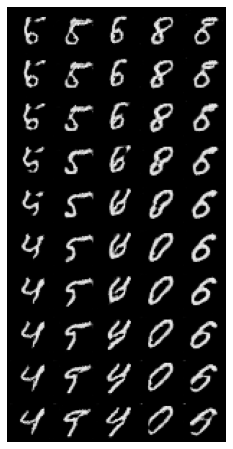

In [13]:
gen = gen.eval()

n_interpolation = 10 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)

def interpolate_class(n_view=5):
    interpolation_noise = generate_noise(n_view, noise_dim, device=device).repeat(n_interpolation, 1)
    first_label = generate_noise(1, c_dim).repeat(n_view, 1)[None, :]
    second_label = first_label.clone()
    first_label[:, :, 0] =  -2
    second_label[:, :, 0] =  2

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label
    interpolation_labels = interpolation_labels.view(-1, c_dim)

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation * n_view, nrow=n_view, show=False)

plt.figure(figsize=(8, 8))
interpolate_class()
_ = plt.axis('off')

Also, we can visualize the impact of pairwise changes of the latent code for a given noise vector.

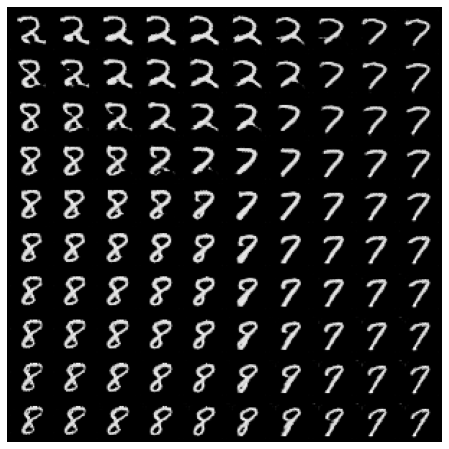

In [29]:
n_interpolation = 10 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)

def interpolate_class():
    interpolation_noise = generate_noise(1, noise_dim, device=device).repeat(n_interpolation * n_interpolation, 1)
    first_label = generate_noise(1, c_dim).repeat(n_interpolation * n_interpolation, 1)
    
    # Calculate the interpolation vector between the two labels
    first_label = torch.linspace(-2, 2, n_interpolation).repeat(n_interpolation)
    second_label = torch.linspace(-2, 2, n_interpolation).repeat_interleave(n_interpolation)
    interpolation_labels = torch.stack([first_label, second_label], dim=1) 

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation * n_interpolation, nrow=n_interpolation, show=False)

plt.figure(figsize=(8, 8))
interpolate_class()
_ = plt.axis('off')


--------
# Ramin F. - @SimplyRamin
This notebook was heavily implied with GANs Specialization by Deeplearning.ai